In [3]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,plot_outline,plot_dendrogram,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [5]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is graph of median topologies and dendrogram cluster graph
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
t_name="T63"
loud=[0,0,0,0,0,0,0,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
interest2=["CH4@100 bar/298 K (mg/g)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],interest2[0],'topology']]=data[['MOF ID',interest[0],interest2[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],interest2[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
abridge["MOF ID"]=abridge.index
# generate holder for dataframes for looping 
if loud[2]:
    a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
    plt.scatter(a["Pc1"],a["Pc2"])
    color = AgglomerativeClustering(n_clusters=g_comp).fit_predict(a)
    #color=gm.predict(a)
    plt.scatter(a["Pc1"],a["Pc2"],c=color)
    plt.legend()
    plot_outline(abridge)


    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(a)
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model,a, truncate_mode="level", p=3)
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
model = AgglomerativeClustering(n_clusters=g_comp)
model = model.fit(a)
model.labels_
dic={}
for a,b in zip(a.index,model.labels_):
    dic[a]=b
abridge["t_cluster"]=abridge["topology"].map(dic)
O_M_Cluster=[]
for i in sorted(abridge["t_cluster"].unique()):
    Temp=abridge[abridge["t_cluster"]==i]
    O_M_Cluster.append(Temp)

# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
resolution=100
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
resize=True
#specify cluster
meta_trials=2
meta=[]
figure_df=pd.DataFrame(columns=["MOF ID","Count","Value"])
figure_df["MOF ID"]=abridge["MOF ID"]
figure_df["Count"]=0
figure_df["Value"]=0
figure_df=figure_df.join(abridge[["MOF ID","t_cluster"]],how="inner",on="MOF ID",rsuffix="r").drop(columns=["MOF IDr"])
figure_dic={"0" : figure_df.copy(deep=True),
            "1" : figure_df.copy(deep=True),
            "2" : figure_df.copy(deep=True),
            "3" : figure_df.copy(deep=True),
            "4" : figure_df.copy(deep=True),
            "5" : figure_df.copy(deep=True),
}
if loud[7]:
    counter=0
for seed,i in enumerate(range(meta_trials)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    #create holder for meta anaylsis
    mega={}
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    for i in range(len(M_Cluster)):
        mega[i]=[]
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[3]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[4]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, f"{t_name}.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load(f"{t_name}.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False
            interest=interest2
            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[5]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
            temp=pd.DataFrame([data.iloc[df_test.index]["MOF ID"].to_numpy(),model(test_loader.dataset.x_train).detach().numpy().flatten()]).T
            temp.columns=["MOF ID","Value"]
            figure_dic[str(cluster)].join(temp,how="left",on="MOF ID",lsuffix="_left").drop("MOF ID_left",axis=1)
            figure_dic[str(cluster)].loc[data.iloc[df_test.index]["MOF ID"].to_numpy(),"Value"]+=model(test_loader.dataset.x_train).detach().numpy().flatten()
            figure_dic[str(cluster)].loc[data.iloc[df_test.index]["MOF ID"].to_numpy(),"Count"]+=1
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[6]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    if loud[7]:
        counter+=1
        print(counter)
    meta.append(mega)

1
2


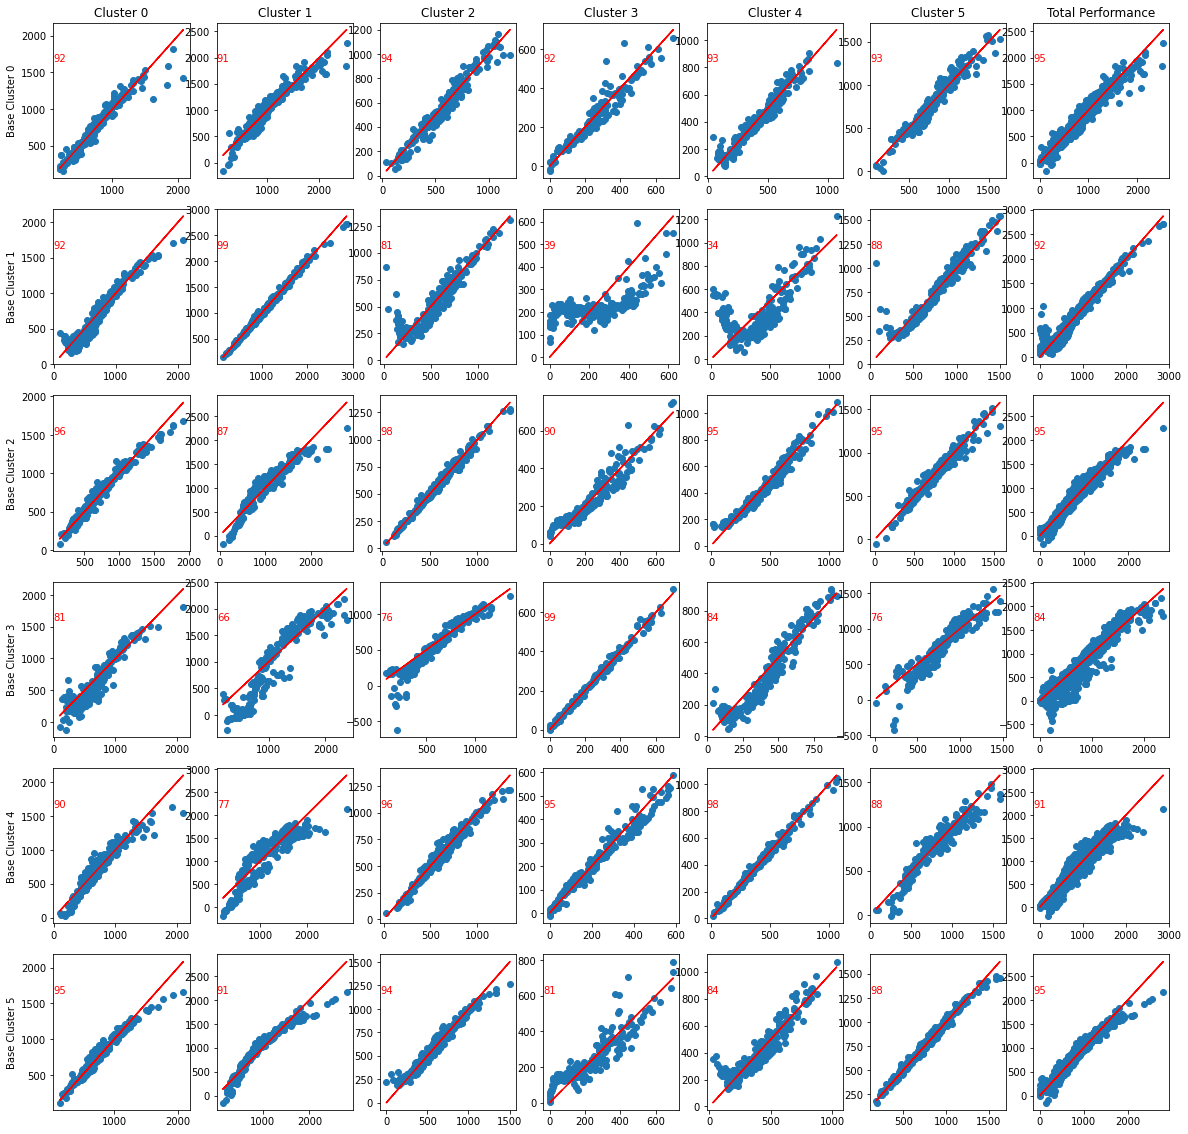

In [16]:
fig, axs = plt.subplots(6,7, figsize=(20,20))
for count,g in enumerate(figure_dic):
    temp=figure_dic[str(g)]
    slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]==1]["MOF ID"])]
    slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
    temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
    slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
    for i in range(6):
        subset=slice[slice["t_cluster"]==i]
        axs[count,i].scatter(subset[interest],subset["Prediction"])
        axs[count,i].plot(subset[interest].to_numpy(),subset[interest].to_numpy(),c="r")
        axs[count,i].text(0,.8,str(int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,i].transAxes)
    axs[count,6].text(0,.8,str(int(100*r2_score(slice[interest].to_numpy(),slice["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,6].transAxes)
    axs[count,6].scatter(slice[interest],slice["Prediction"])
    axs[count,6].plot(slice[interest].to_numpy(),slice[interest].to_numpy(),c="r")
    axs[0,0].set_title("Cluster 0")
    axs[0,1].set_title("Cluster 1")
    axs[0,2].set_title("Cluster 2")
    axs[0,3].set_title("Cluster 3")
    axs[0,4].set_title("Cluster 4")
    axs[0,5].set_title("Cluster 5")
    axs[0,6].set_title("Total Performance")
    axs[count,0].set_ylabel(f"Base Cluster {count}")

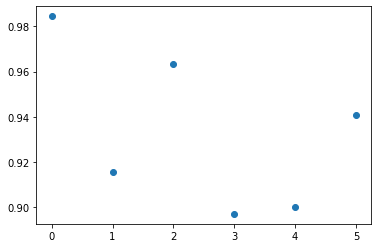

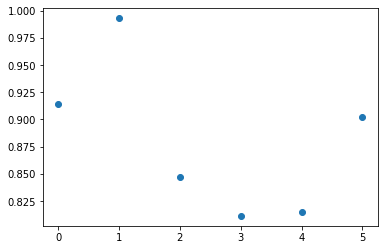

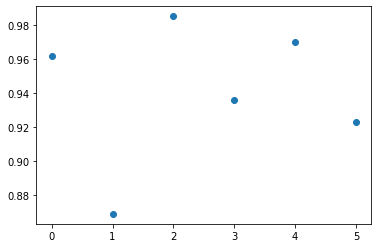

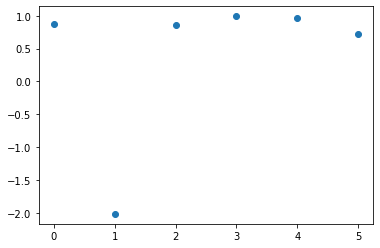

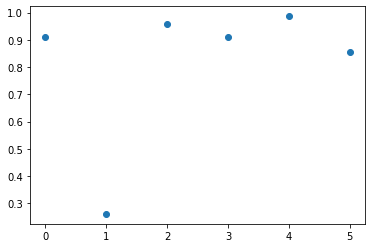

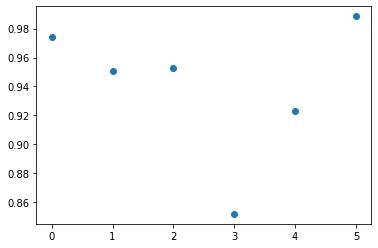

In [24]:
for i in mega:
    a=[]
    for g in range(6):
        a.append(mega[i][g][-1])
    plt.scatter(range(6),a)
    plt.show()

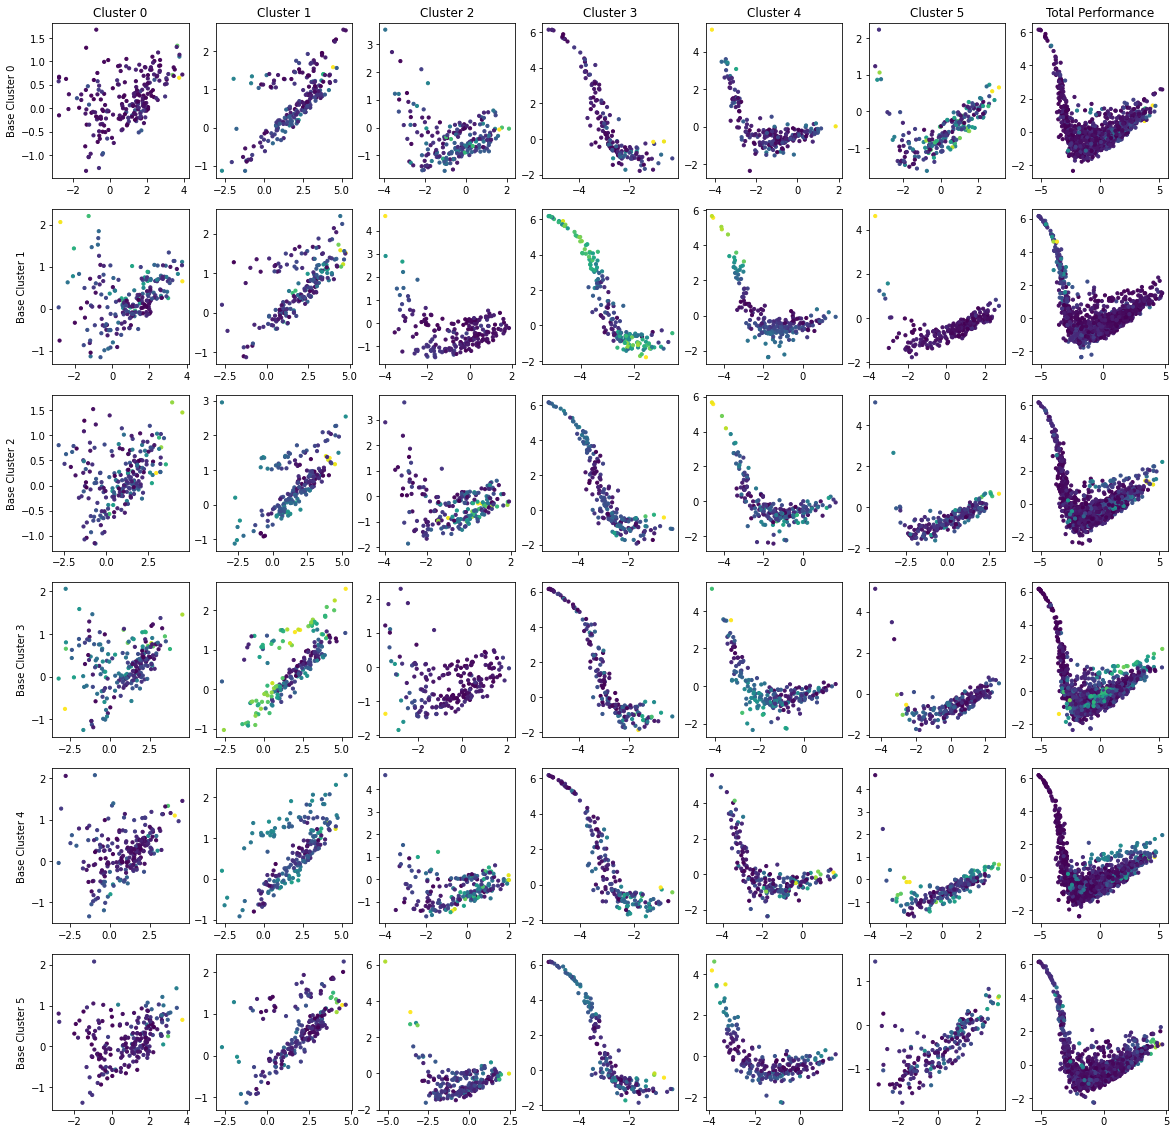

In [7]:
fig, axs = plt.subplots(6,7, figsize=(20,20))
for count,g in enumerate(figure_dic):
    temp=figure_dic[str(g)]
    slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]==1]["MOF ID"])]
    slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
    temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
    slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
    slice["Error"]=slice.apply(lambda x: abs(x[interest]-x["Prediction"]),axis=1)
    for i in range(6):
        subset=slice[slice["t_cluster"]==i]
        axs[count,i].scatter(subset["Pc1"],subset["Pc2"],cmap="viridis",c=subset["Error"],s=10)
    axs[count,6].scatter(slice["Pc1"],slice["Pc2"],cmap="viridis",c=slice["Error"],s=10)
    axs[0,0].set_title("Cluster 0")
    axs[0,1].set_title("Cluster 1")
    axs[0,2].set_title("Cluster 2")
    axs[0,3].set_title("Cluster 3")
    axs[0,4].set_title("Cluster 4")
    axs[0,5].set_title("Cluster 5")
    axs[0,6].set_title("Total Performance")
    axs[count,0].set_ylabel(f"Base Cluster {count}")

In [3]:
for i in M_Cluster:
    print(len(i))
    number=i["t_cluster"].unique()
    print(i["topology"].unique(),f"Cluster {number[0]}")

561
['stp' 'the' 'sodb' 'rhrb' 'ctn' 'bor' 'csq' 'tpt' 'ssa' 'crs'] Cluster 0
561
['tbo' 'spn' 'srsb'] Cluster 1
561
['iac' 'pth' 'she' 'pyr' 'nbob' 'soc'] Cluster 2
561
['bcu' 'ith' 'bct' 'bcs' 'fcu'] Cluster 3
561
['scu' 'flu' 'ocu' 'gar' 'pcu' 'ftw' 'lvtb' 'rht' 'acs' 'nia' 'reo'] Cluster 4
561
['pts' 'pto' 'ssb' 'lcsb' 'diab' 'qtz'] Cluster 5


In [4]:
import json
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
outs=[epoch_conversions,byte,epochs,resolution]
o_name=["epoch_conversions","byte","epochs","resolution"]
for a,b in zip(outs,o_name):
    print(f"Variable {b} is {a}")
with open('h277-ch4.json', 'w') as f:
    json.dump(meta, f)

Variable epoch_conversions is [561, 561, 561, 561, 561, 561]
Variable byte is 268
Variable epochs is 500
Variable resolution is 100
